<a href="https://colab.research.google.com/github/nhon14/Rice-Type-Classification/blob/main/RiceTypeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team:
        
     Nathan Hon

# Business Understanding
For this project I have selected a subset of an image dataset containing five different classes of rice. I have used a smaller subset of 5000 images (1000 of each class of rice) due to limitation of RAM as well as for a more manageable processing time due to time constraints. My goal is to use deep learning architecture, convolutional network architectures in this case, to assist with training and predicting the different types of rice. As we will see below, the images are simpler and do not have as much noise in the background, my goal for this project is to show the effectiveness of convolutional neural networks and to compare them against other architectures such as the multiple layer perceptron. The dataset used is "Rice Image Dataset" by Murat Koklu, it is found on Kaggle at this link: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/code?datasetId=2049052&sortBy=voteCount

This report aims to demonstrate the effectiveness of using CNN architecture which can be further used on more complex data to assist industries such as the agriculture business through deep learning architecture in efficient identification of various product types.

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Loading and Splitting Dataset

Here we load in the image paths and labels for the dataset. As seen below, the five types of rice we will analyze and predict are Karacadag, Basmati, Jasmine, Arborio, and Ipsala.

In [ ]:
unique_labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

data_dir = '/content/drive/MyDrive/Rice_Dataset/'

all_paths = []
all_labels = []

for label in unique_labels:
    for image_path in os.listdir(data_dir+label):
        img = cv2.imread(data_dir+label+'/'+image_path)
        img_resize = cv2.resize(img, dsize=(100, 100))
        # img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
        all_paths.append(img_resize)
        if(label == "Arborio"):
          all_labels.append(1)
        elif(label == "Basmati"):
          all_labels.append(2)
        elif(label == "Ipsala"):
          all_labels.append(3)
        elif(label == "Jasmine"):
          all_labels.append(4)
        elif(label == "Karacadag"):
          all_labels.append(5)

# store image paths and labels
all_paths, all_labels = shuffle(all_paths, all_labels)

### Choice of Metric: Classification Accuracy
As I will explain further below, my dataset contains lower resolution images of individual grains of rice of five different types. Despite lowering the resolution and using a smaller total of 5000 images I was able to attain a high accuracy rate of over 90% on average. However, for this dataset even 70-80% would be sufficient as the risk of wrongly predicting data is relatively low compared to medical datasets that could put people in a life or death situation depending on the prediction results. In this case, as stated above, the use of the results will most likely be sufficient for agricultural business or as a learning tool in academia. However, the risk of misclassifying rice types could have a negative effect financially, so ensuring that accuracy is at least above 70% is important.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_paths, all_labels,
                                                              test_size=0.2, random_state=42, shuffle = True,
                                                              stratify=all_labels)

### Train, Test, Split


*   The dataset used contains images of five different classes of rice as seen in the image below. I first loaded in the images and then stored images in the train and test variables of X and the labels in the train and test variables of y.
*   Originally, the dataset contained 50,000 images with 10,000 of each rice type. I cut this down to a total of 5,000 equally split because due to the clarity of the images and the ratio of the 5,000 to 5 classes seemed sufficient to achieve high accuracy with low loss as seen in my model results below.
*   As seen in the code block above, I split the training and test 80%/20% and it was sufficient for the results below. I also utilized shuffle in order to randomize data being trained so that it wouldn't be iterating through the exact same data with each epoch. I also used stratify in order to ensure that my data in my training and testing variables represented each rice type equally.
*   Lastly, I also had reduced the original number of images due to memory constraints as well as decreasing the image resolution to 100x100. Although this may decrease accuracy, the effects are minimal due to the image set being relatively clear with black backgrounds making it easier for the training models to process.



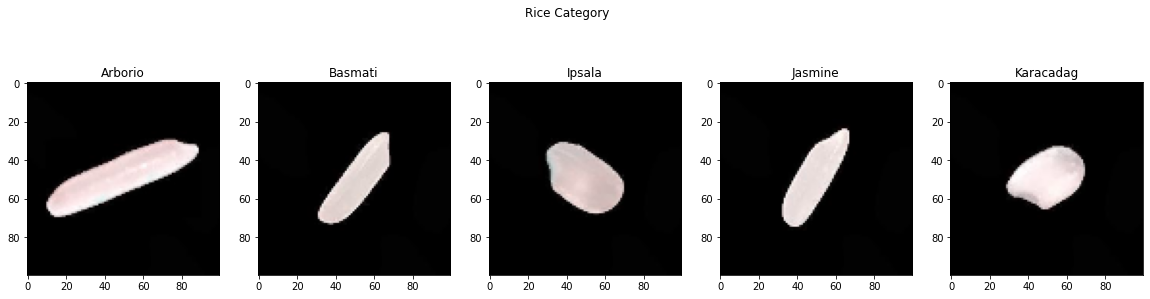

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')
ax[0].set_title('Arborio')
ax[1].set_title('Basmati')
ax[2].set_title('Ipsala')
ax[3].set_title('Jasmine')
ax[4].set_title('Karacadag')


ax[0].imshow(all_paths[100],cmap='gray')
ax[1].imshow(all_paths[1100],cmap='gray')
ax[2].imshow(all_paths[2100],cmap='gray')
ax[3].imshow(all_paths[3100],cmap='gray')
ax[4].imshow(all_paths[4100],cmap='gray')

In [ ]:
del [all_paths, all_labels]

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

In [ ]:
y_train_ohe = keras.utils.to_categorical(y_train,6)
y_test_ohe = keras.utils.to_categorical(y_test,6)

In [ ]:
del [y_test,y_train ]

### Data Expansion in Keras
Below I used the Keras fit generator as  pre-processing step prior to applying multiple CNNs to my data. As seen below, I am using rotation, width and height shift, as well as horizontal flip. Slightly altering the image data is helpful in my case, whether through rotation, vertical or horizontal shifting or flipping, due to the fact that the images in my dataset having a lot of similar images since each rice type has 1000 images. The images in my dataset also appear to be centered on a black background therefore shifting it a little off center also helps generate new images that could help improve image prediction accuracy.

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

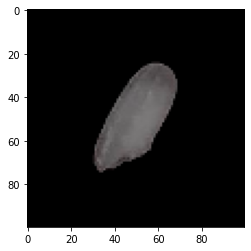

In [ ]:
plt.imshow(X_train[121],cmap=plt.get_cmap('gray'))


# Modeling

## Model 1: Ensemble Nets Variation 1

1.   L2 Regularization

In [ ]:
%%time

img_wh = 100
NUM_CLASSES = 6

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 3
l2_lambda = 0.000001
#l1 for second variation
#replace    kernel_regularizer=keras.regularizers.l2(l2_lambda),
#with this:
# kernel_regularizer=keras.regularizers.l1_l2(l1_lambda, l2_lambda)
# l1_lambda = 0.00001


input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=keras.regularizers.l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=keras.regularizers.l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=keras.regularizers.l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [ ]:
%%time
# the flow method yields batches of images indefinitely, with the given transformations
cnn1_history = cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])

<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
31/31 [==============================] - 222s 7s/step - loss: 1.8765 - accuracy: 0.3595 - val_loss: 1.2000 - val_accuracy: 0.5430
Epoch 2/50
31/31 [==============================] - 221s 7s/step - loss: 1.0227 - accuracy: 0.6126 - val_loss: 0.7758 - val_accuracy: 0.6830
Epoch 3/50
31/31 [==============================] - 224s 7s/step - loss: 0.6993 - accuracy: 0.7265 - val_loss: 0.5045 - val_accuracy: 0.7730
Epoch 4/50
31/31 [==============================] - 220s 7s/step - loss: 0.5085 - accuracy: 0.7629 - val_loss: 0.4139 - val_accuracy: 0.7810
Epoch 5/50
31/31 [==============================] - 228s 7s/step - loss: 0.4457 - accuracy: 0.7895 - val_loss: 0.2833 - val_accuracy: 0.8570
Epoch 6/50
31/31 [==============================] - 222s 7s/step - loss: 0.3010 - accuracy: 0.9008 - val_loss: 0.1770 - val_accuracy: 0.9360
Epoch 7/50
31/31 [==============================] - 225s 7s/step - loss: 0.3303 - accuracy: 0.8982 - val_loss: 0.2132 - val_accuracy: 0.9330
Epoch 8/50
31

In [ ]:
del[cnn_ens]

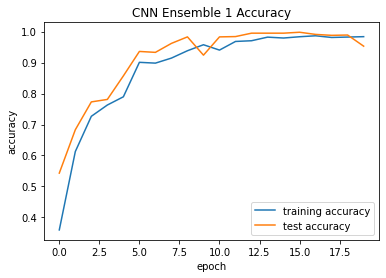

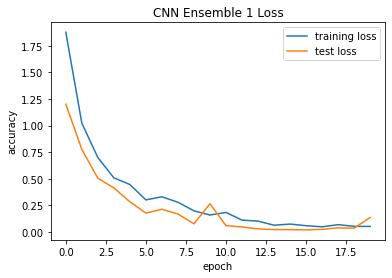

In [ ]:
cnn1_history.history
plt.plot(cnn1_history.history["accuracy"])
plt.plot(cnn1_history.history["val_accuracy"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('CNN Ensemble 1 Accuracy')
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()
#-----------------------------------------
plt.plot(cnn1_history.history["loss"])
plt.plot(cnn1_history.history["val_loss"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('CNN Ensemble 1 Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

## Model 2: Ensemble Nets Variation 2

1.   L1 Regularization



In [ ]:
%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

img_wh = 100
NUM_CLASSES = 6

num_ensembles = 3
l2_lambda = 0.000001
#l1 for second variation
#replace    kernel_regularizer=keras.regularizers.l2(l2_lambda),
#with this:
# kernel_regularizer=keras.regularizers.l1_l2(l1_lambda, l2_lambda)
l1_lambda = 0.00001


input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l1(l1_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l1(l1_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l1(l1_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=keras.regularizers.l1(l1_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=keras.regularizers.l1(l1_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=keras.regularizers.l1(l1_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=keras.regularizers.l1(l1_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens2 = Model(inputs=input_holder,outputs=x)

cnn_ens2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Let's train the model 
cnn_ens2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [ ]:
%%time
# the flow method yields batches of images indefinitely, with the given transformations
cnn2_history = cnn_ens2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])

<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
31/31 [==============================] - 249s 8s/step - loss: 2.1772 - accuracy: 0.4773 - val_loss: 0.8551 - val_accuracy: 0.7570
Epoch 2/50
31/31 [==============================] - 246s 8s/step - loss: 0.8153 - accuracy: 0.8120 - val_loss: 0.7732 - val_accuracy: 0.8030
Epoch 3/50
31/31 [==============================] - 247s 8s/step - loss: 0.6291 - accuracy: 0.8884 - val_loss: 0.4760 - val_accuracy: 0.9460
Epoch 4/50
31/31 [==============================] - 245s 8s/step - loss: 0.4812 - accuracy: 0.9463 - val_loss: 0.4106 - val_accuracy: 0.9720
Epoch 5/50
31/31 [==============================] - 245s 8s/step - loss: 0.4570 - accuracy: 0.9522 - val_loss: 0.4098 - val_accuracy: 0.9690
Epoch 6/50
31/31 [==============================] - 243s 8s/step - loss: 0.4442 - accuracy: 0.9509 - val_loss: 0.3958 - val_accuracy: 0.9680
Epoch 7/50
31/31 [==============================] - 245s 8s/step - loss: 0.4186 - accuracy: 0.9576 - val_loss: 0.4030 - val_accuracy: 0.9600
Epoch 8/50
31

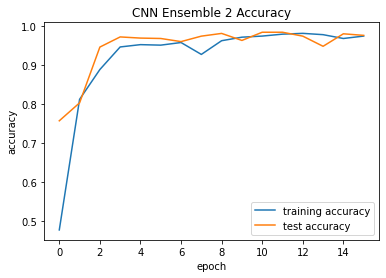

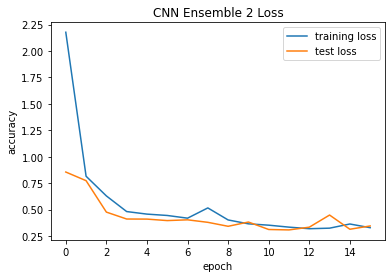

In [ ]:
cnn2_history.history
plt.plot(cnn2_history.history["accuracy"])
plt.plot(cnn2_history.history["val_accuracy"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('CNN Ensemble 2 Accuracy')
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()
#-----------------------------------------
plt.plot(cnn2_history.history["loss"])
plt.plot(cnn2_history.history["val_loss"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('CNN Ensemble 2 Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

## Model 3: Resnet Variation 1

In [ ]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

img_wh = 100

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 100, 100, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 50, 50, 32)  0           ['conv2d_19[0][0]']              
 )                                                                                          

In [ ]:
%%time
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

resnet1_history = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                     )

Epoch 1/50
32/32 [==============================] - 80s 2s/step - loss: 1.4005 - accuracy: 0.5625 - val_loss: 0.2019 - val_accuracy: 0.9600
Epoch 2/50
32/32 [==============================] - 71s 2s/step - loss: 0.1777 - accuracy: 0.9410 - val_loss: 0.0807 - val_accuracy: 0.9740
Epoch 3/50
32/32 [==============================] - 72s 2s/step - loss: 0.0994 - accuracy: 0.9672 - val_loss: 0.0453 - val_accuracy: 0.9850
Epoch 4/50
32/32 [==============================] - 71s 2s/step - loss: 0.0870 - accuracy: 0.9720 - val_loss: 0.0473 - val_accuracy: 0.9850
Epoch 5/50
32/32 [==============================] - 70s 2s/step - loss: 0.0692 - accuracy: 0.9772 - val_loss: 0.0428 - val_accuracy: 0.9840
Epoch 6/50
32/32 [==============================] - 69s 2s/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.0376 - val_accuracy: 0.9870
Epoch 7/50
32/32 [==============================] - 70s 2s/step - loss: 0.0647 - accuracy: 0.9797 - val_loss: 0.0378 - val_accuracy: 0.9890
Epoch 8/50
32/32 [==

In [ ]:
del[resnet]

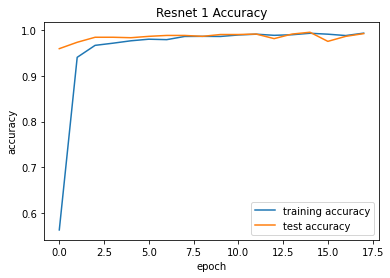

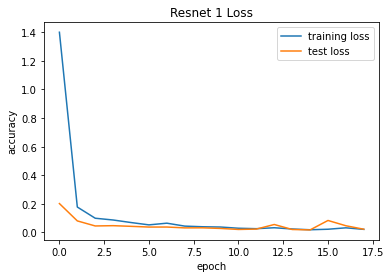

In [ ]:
resnet1_history.history
plt.plot(resnet1_history.history["accuracy"])
plt.plot(resnet1_history.history["val_accuracy"]) 
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('Resnet 1 Accuracy')
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()

#-----------------------------------------
plt.plot(resnet1_history.history["loss"])
plt.plot(resnet1_history.history["val_loss"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('Resnet 1 Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

## Model 4: Resnet Variation 2

In [ ]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

img_wh = 100

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=keras.regularizers.l1(l1_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 100, 100, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 50, 50, 32)  0           ['conv2d_14[0][0]']              
                                                                                            

In [ ]:
%%time
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

resnet2_history = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)]
                     )

Epoch 1/50
32/32 [==============================] - 80s 2s/step - loss: 1.3650 - accuracy: 0.5680 - val_loss: 0.3294 - val_accuracy: 0.9330
Epoch 2/50
32/32 [==============================] - 72s 2s/step - loss: 0.3324 - accuracy: 0.8907 - val_loss: 0.1461 - val_accuracy: 0.9670
Epoch 3/50
32/32 [==============================] - 71s 2s/step - loss: 0.2125 - accuracy: 0.9317 - val_loss: 0.1281 - val_accuracy: 0.9640
Epoch 4/50
32/32 [==============================] - 71s 2s/step - loss: 0.1576 - accuracy: 0.9572 - val_loss: 0.1097 - val_accuracy: 0.9750
Epoch 5/50
32/32 [==============================] - 73s 2s/step - loss: 0.1457 - accuracy: 0.9605 - val_loss: 0.0871 - val_accuracy: 0.9780
Epoch 6/50
32/32 [==============================] - 69s 2s/step - loss: 0.1335 - accuracy: 0.9675 - val_loss: 0.0883 - val_accuracy: 0.9800
Epoch 7/50
32/32 [==============================] - 72s 2s/step - loss: 0.1124 - accuracy: 0.9750 - val_loss: 0.0862 - val_accuracy: 0.9810
Epoch 8/50
32/32 [==

In [ ]:
del[resnet]

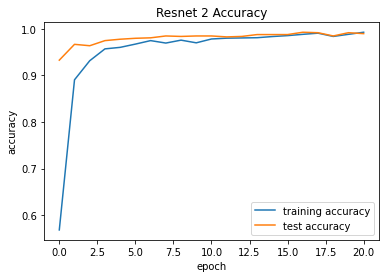

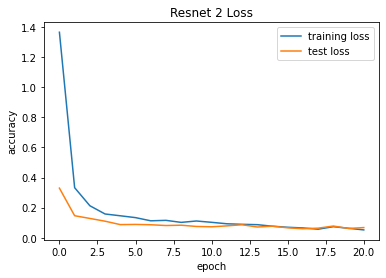

In [ ]:
resnet2_history.history
plt.plot(resnet2_history.history["accuracy"])
plt.plot(resnet2_history.history["val_accuracy"]) 
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Resnet 2 Accuracy')
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()

#-----------------------------------------
plt.plot(resnet2_history.history["loss"])
plt.plot(resnet2_history.history["val_loss"])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Resnet 2 Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

## CNN Interpretations and Comparisons
### Ensemble 1 vs Ensemble 2(L2 vs L1):
Ensemble learning generally involves training multiple networks on the same dataset, making a prediction within each network and combining them for a final outcome. This helps to reduce variance as well as resulting in a better prediction. Ensemble 1 uses L2 regularization whereas Ensemble 2 uses L1 regularization. The Ensemble 1 model using L2 regularization reaches its peak accuracy of 99.8% at epoch 16 whereas Ensemble 2 using L1 regularization reaches its peak of 98.4% at epoch 11. We also notice that Ensemble 2’s data appears more sparse which aligns with the fact that L1 regularization results in sparser data as it shrinks parameters to 0 while Ensemble 1’s L2 regularization shrinks parameters near 0 but not to 0 resulting in results that are not sparse. Although Ensemble 1 has a 1.4% advantage in accuracy, Ensemble 2 is preferred in this scenario as accuracies of over 70% would already be sufficient and the time saved from running 11 epochs as opposed to 16 is valuable.

### Ensemble 1 vs Resnet1:
As we can see in the tables for CNN Ensemble 1, peak test accuracy was reached at 99.8% at epoch 16 whereas for Resnet 1, peak test accuracy of 99.6% at epoch 15. CNN Ensemble 1 with L2 regularization and without Resnet has a slightly higher peak accuracy while Resnet 1 has a slightly quicker rate to reach max accuracy at 15 epochs compared to 16. As stated before due to the nature of this particular dataset, the added 0.2% increase in accuracy with Ensemble 1 is not needed while the improvement of 1 epoch for Resnet 1 to reach its maximum accuracy in this case is more valuable and sufficient for this scenario.

### Ensemble 2 vs Resnet2:
The CNN model Ensemble 2 using L1 regularization reaches its peak of 98.4% at epoch 11 while Resnet 2 reached a peak accuracy of 99.3% at epoch 17. As stated before, we prefer CNN Ensemble 2 in this scenario due to a preference for efficiency along with a reasonably high accuracy rate. However, other scenarios with much higher definition and complex images are more likely to prefer Resnet 2 especially in cases where it is difficult to train a model. The reason higher definition and complex images are likely to benefit more from Resnet 2 is because Resnet is designed to prevent the issue of vanishing gradient by skipping layers that are likely to increase error rates.

### Resnet 1 vs Resnet 2:
Resnet 1 reached a peak accuracy of 99.6% at 15 epochs while Resnet 2 reached its peak acurracy of 99.3% at epoch 17. In this case Resnet 1 has both a higher peak accuracy as well as a faster rate in reaching its peak.

### Best Fit Model
The CNN model Ensemble 2 which uses L1 regularization is the best model for this particular scenario as the model that provides the fastest rate at reaching its peak accuracy while still resulting in a high accuracy rate of 98.4%. Despite its peak accuracy being slightly lower than a few other CNN models, it is more than sufficient in being effective at predicting the 5 different types of rice in our dataset. The efficiency of this model can save time and potentially money which can be a helpful tool to businesses in the agriculture industry.

### MLP Adaptation

In [ ]:
%%time
model = Sequential()
model.add(Flatten())
model.add(Dense(input_dim = 1000, units = 2500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlphistory = model.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)]
                     )

Epoch 1/50
32/32 [==============================] - 35s 1s/step - loss: 19.2112 - accuracy: 0.3273 - val_loss: 1.8729 - val_accuracy: 0.3860
Epoch 2/50
32/32 [==============================] - 38s 1s/step - loss: 0.6155 - accuracy: 0.7600 - val_loss: 0.3298 - val_accuracy: 0.8810
Epoch 3/50
32/32 [==============================] - 32s 1s/step - loss: 0.2374 - accuracy: 0.9285 - val_loss: 0.2063 - val_accuracy: 0.9400
Epoch 4/50
32/32 [==============================] - 36s 1s/step - loss: 0.1581 - accuracy: 0.9505 - val_loss: 0.1330 - val_accuracy: 0.9600
Epoch 5/50
32/32 [==============================] - 32s 999ms/step - loss: 0.1043 - accuracy: 0.9682 - val_loss: 0.0985 - val_accuracy: 0.9720
Epoch 6/50
32/32 [==============================] - 32s 997ms/step - loss: 0.0921 - accuracy: 0.9665 - val_loss: 0.0855 - val_accuracy: 0.9750
Epoch 7/50
32/32 [==============================] - 32s 999ms/step - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.2539 - val_accuracy: 0.8920
Epoch 8/50

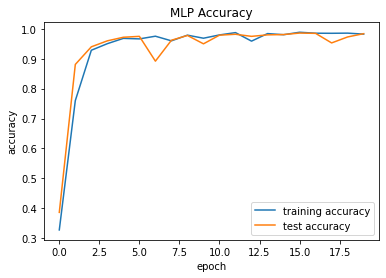

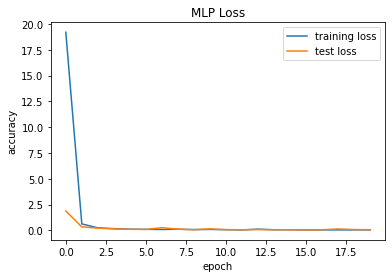

In [ ]:
mlphistory.history
plt.plot(mlphistory.history["accuracy"])
plt.plot(mlphistory.history["val_accuracy"]) 
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('MLP Accuracy') 
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()

#-----------------------------------------
plt.plot(mlphistory.history["loss"])
plt.plot(mlphistory.history["val_loss"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('MLP Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

### MLP vs CNN Comparisons
We will now compare our chosen best fit CNN model (CNN Ensemble 2) with an MLP model. As stated before, Ensemble 2 reached a peak accuracy of 98.4% at epoch 11. On the other hand, MLP reached a peak accuracy level of 98.6% at epoch 16. Although the MLP is slightly more accurate, it is also much slower and less efficient at reaching its peak accuracy. Also it is important to note that CNN are more effective at processing complex images due to their ability to understand spatial relation, whereas MLP is effective for simple images, which is likely why we see such a high accuracy rate for this dataset.

Reference: https://www.linkedin.com/pulse/mlp-vs-cnn-rnn-deep-learning-machine-model-momen-negm/


## Transfer Learning with Resnet

In [ ]:
# connect new layers to the output
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
%%time
resTransferModel = Sequential()
preTrans = ResNet50(include_top = False, classes = 6, weights='imagenet')
resTransferModel.add(Flatten())
resTransferModel.add(Dense(500, activation='relu'))
resTransferModel.add(Dense(250, activation='relu'))
resTransferModel.add(Dense(6, activation='softmax'))

# Configure the resTransferModel and start training
resTransferModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resTransferHistory = resTransferModel.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=20, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)] # 13 epochs last time
                     )

Epoch 1/20
32/32 [==============================] - 12s 330ms/step - loss: 7.8711 - accuracy: 0.4420 - val_loss: 0.7758 - val_accuracy: 0.6480
Epoch 2/20
32/32 [==============================] - 8s 248ms/step - loss: 0.4311 - accuracy: 0.8100 - val_loss: 0.2069 - val_accuracy: 0.9380
Epoch 3/20
32/32 [==============================] - 9s 271ms/step - loss: 0.1348 - accuracy: 0.9635 - val_loss: 0.1515 - val_accuracy: 0.9500
Epoch 4/20
32/32 [==============================] - 8s 253ms/step - loss: 0.1007 - accuracy: 0.9778 - val_loss: 0.1365 - val_accuracy: 0.9520
Epoch 5/20
32/32 [==============================] - 7s 212ms/step - loss: 0.0971 - accuracy: 0.9730 - val_loss: 0.1156 - val_accuracy: 0.9620
Epoch 6/20
32/32 [==============================] - 7s 212ms/step - loss: 0.0818 - accuracy: 0.9750 - val_loss: 0.0936 - val_accuracy: 0.9700
Epoch 7/20
32/32 [==============================] - 7s 212ms/step - loss: 0.0686 - accuracy: 0.9820 - val_loss: 0.0985 - val_accuracy: 0.9740
Epoch

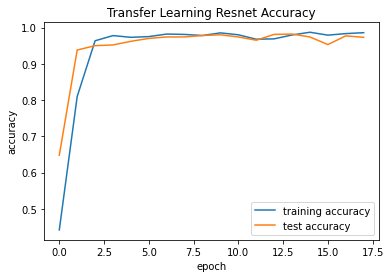

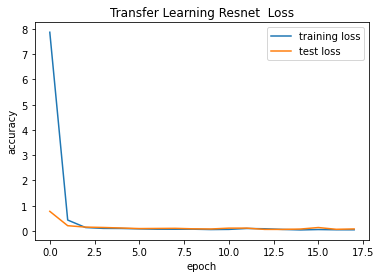

In [ ]:
resTransferHistory.history
plt.plot(resTransferHistory.history["accuracy"])
plt.plot(resTransferHistory.history["val_accuracy"]) 
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('Transfer Learning Resnet Accuracy')
ax = plt.gca()
ax.legend(['training accuracy', 'test accuracy'])
plt.show()
print()

#-----------------------------------------
plt.plot(resTransferHistory.history["loss"])
plt.plot(resTransferHistory.history["val_loss"])
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('Transfer Learning Resnet  Loss')
ax = plt.gca()
ax.legend(['training loss', 'test loss'])
plt.show()

### Best CNN vs Transfer Learning
Our best CNN model, Ensemble 1, produced a peak accuracy rate of 98.4% at epoch 11 while our Transfer Learning Resnet model produced a peak accuracy of 98.2% at epoch 14. However, the actual running time for Ensemble 1 was 1 hour and 10 minutes whereas our Transfer Learning model only took 3 minutes and 53 seconds. The lower epochs from our Ensemble 1 model could mean that there is less of a chance of overfitting however because we have Early Stopping applied to all our models as a preventative, the time efficiency along with a high accuracy of 98.2% would put our Transfer Learning model as the most preferred deep learning model for our dataset.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab6.ipynb

[NbConvertApp] Converting notebook /content/Lab6.ipynb to html
[NbConvertApp] Writing 784755 bytes to /content/Lab6.html
